In [1]:
EPOCH = 16

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.optimizers import Adam
import keras
import numpy as np
import matplotlib.pyplot as plt

from config import config_parser
from mp_util_legacy import preprocess_keypoints_multiple

In [3]:
class KeypointDataGenerator(keras.utils.Sequence):
    def __init__(self, keypoint_path, seq_max_len, batch_size=32, shuffle=False, transform=False):
        self.keypoint_path = keypoint_path
        self.seq_max_len = seq_max_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.transform = transform
        
        self.file_list = []
        self.labels = []

        self.all_labels = sorted(os.listdir(keypoint_path))
        for label in self.all_labels:
            for file in os.listdir(os.path.join(keypoint_path, label)):
                self.file_list.append(file)
                self.labels.append(label)
        self.epoch_count = -1
        self.on_epoch_end()

    def reset_epoch(self):
        self.epoch_count = -1
        self.on_epoch_end()

    def on_epoch_end(self):
        self.epoch_count += 1
        np.random.seed(self.epoch_count * 42)
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.file_list) / self.batch_size))
    
    def preprocess_keypoints(self, keypoints):
        angle = np.random.randint(-20, 20)
        tx = np.random.uniform(-0.4, 0.4)
        ty = np.random.uniform(-0.4, 0.4)
        scale = np.random.uniform(0.6, 1.2)
        return preprocess_keypoints_multiple(keypoints, angle=angle, tx=tx, ty=ty, scale=scale)

    def __data_generation(self, indexes):
        sequences = []
        labels = []

        for index in indexes:
            kp_file_name = self.file_list[index]
            label = self.labels[index]
            sequences.append(np.load(os.path.join(self.keypoint_path, label, kp_file_name), mmap_mode="r"))
            labels.append(label)

        for i in range(len(sequences)):
            if self.transform:
                sequences[i] = self.preprocess_keypoints(sequences[i])
            sequences[i] = sequences[i].reshape(self.seq_max_len, -1)

        X = np.array(sequences)
        Y = np.array([self.all_labels.index(label) for label in labels])
        return X, Y
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X, Y = self.__data_generation(indexes)
        return X, Y

In [4]:
training_generator = KeypointDataGenerator(
    "../dataset/minified_3_fixed/split/train", 
    seq_max_len=30, 
    batch_size=32, 
    shuffle=True, 
    transform=True
)
validation_generator = KeypointDataGenerator(
    "../dataset/minified_3_fixed/split/val",
    seq_max_len=30, 
    batch_size=32, 
    shuffle=False, 
    transform=False
)
test_generator = KeypointDataGenerator(
    "../dataset/minified_3_fixed/split/test",
    seq_max_len=30, 
    batch_size=32, 
    shuffle=False, 
    transform=False
)

In [5]:
def train_model(model, learning_rate, epochs):
    training_generator.reset_epoch()
    validation_generator.reset_epoch()
    test_generator.reset_epoch()
    model.summary()
    model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        training_generator,
        validation_data=validation_generator,
        epochs=epochs,
        verbose=1
    )
    # plot training accuracy and validation accuracy in the same plot
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    # plot training loss and validation loss in the same plot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_generator)
    print('Test loss: {}'.format(test_loss))
    print('Test accuracy: {}'.format(test_acc))

    # return training accuracy of last epoch, validation accuracy of last epoch, test accuracy
    return history.history['accuracy'][-1], history.history['val_accuracy'][-1], test_acc

In [6]:
first_batch = training_generator.__getitem__(0)
X_shape = first_batch[0].shape[1:]
Y_shape = len(training_generator.all_labels)
del first_batch
print(X_shape, Y_shape)
results = {}

(30, 468) 9


# Test 1: LSTM vs GRU (Single Layer)

c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       305,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,825 (1.17 MB)

 Trainable params: 306,825 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16


c:\Users\USER\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.1193 - loss: 2.2350 - val_accuracy: 0.4375 - val_loss: 2.0922
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - accuracy: 0.3517 - loss: 2.0361 - val_accuracy: 0.3281 - val_loss: 1.9636
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.4116 - loss: 1.8721 - val_accuracy: 0.2969 - val_loss: 1.7878
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.4503 - loss: 1.6776 - val_accuracy: 0.2500 - val_loss: 1.6735
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.5625 - loss: 1.4684 - val_accuracy: 0.5000 - val_loss: 1.4357
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.5664 - loss: 1.3329 - val_accuracy: 0.4375 - val_loss: 1.2747
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.6406 - loss: 1.1340 - val_accuracy: 0.6406 - val_loss: 1.1439
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - accuracy: 0.6404 - loss: 1.0285 - val_accuracy: 0.5781 - val

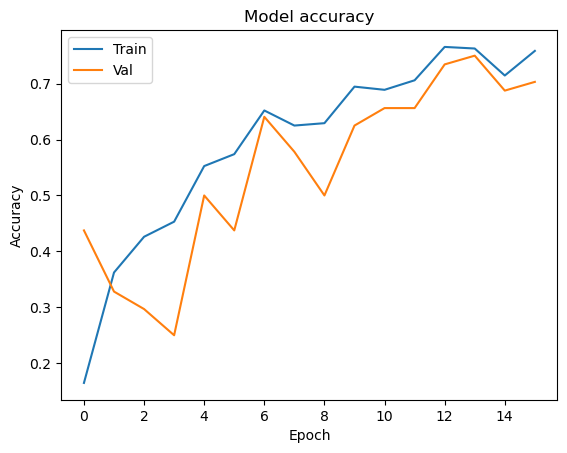

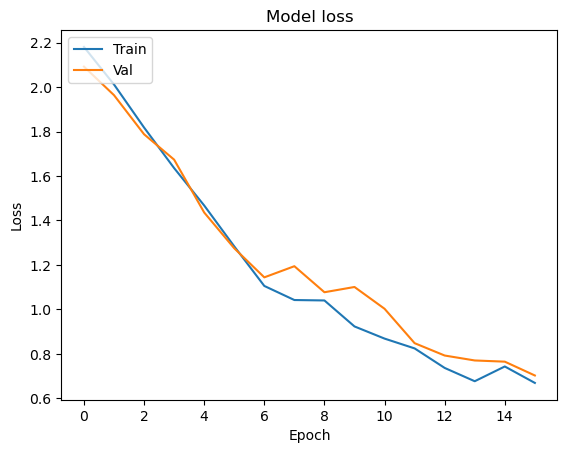

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7188 - loss: 0.7056
Test loss: 0.7027342319488525
Test accuracy: 0.734375


In [7]:
model_test1 = Sequential([
    LSTM(128, input_shape=X_shape, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_single_layer"] = train_model(model_test1, 0.0001, EPOCH)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │       229,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,793 (901.54 KB)

 Trainable params: 230,793 (901.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 283ms/step - accuracy: 0.1126 - loss: 2.2123 - val_accuracy: 0.3750 - val_loss: 2.1110
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - accuracy: 0.3310 - loss: 2.0621 - val_accuracy: 0.3281 - val_loss: 2.0800
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 267ms/step - accuracy: 0.3600 - loss: 1.9891 - val_accuracy: 0.4844 - val_loss: 1.9597
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 0.3895 - loss: 1.8793 - val_accuracy: 0.4688 - val_loss: 1.9144
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.4755 - loss: 1.7761 - val_accuracy: 0.5156 - val_loss: 1.8236
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.4639 - loss: 1.7722 - val_accuracy: 0.4688 - val_loss: 1.7523
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.5069 - loss: 1.6402 - val_accuracy: 0.5156 - val_loss: 1.7027
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.5180 - loss: 1.5772 - val_accuracy: 0

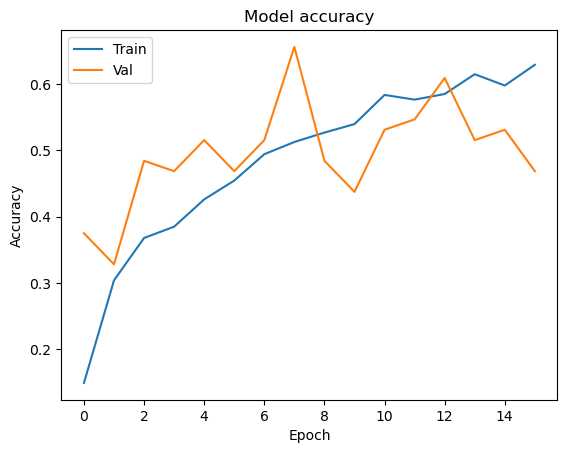

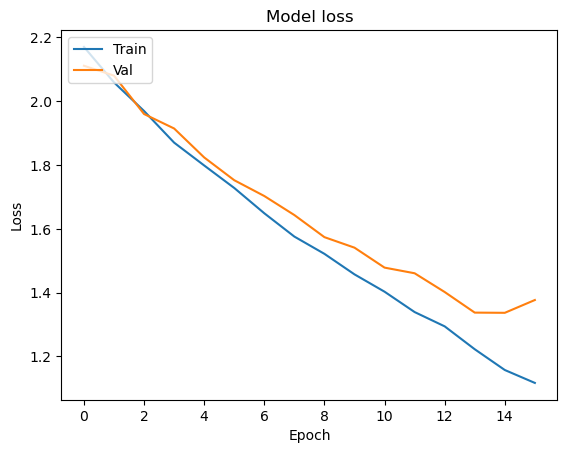

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5208 - loss: 1.2944
Test loss: 1.3491780757904053
Test accuracy: 0.515625


In [8]:
model_test2 = Sequential([
    GRU(128, input_shape=X_shape, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["GRU_single_layer"] = train_model(model_test2, 0.0001, EPOCH)

# Test 2: Multilayer

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │       305,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,409 (1.67 MB)

 Trainable params: 438,409 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - accuracy: 0.1204 - loss: 2.1966 - val_accuracy: 0.4219 - val_loss: 2.0884
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.3712 - loss: 2.0320 - val_accuracy: 0.2031 - val_loss: 1.9033
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.4120 - loss: 1.7612 - val_accuracy: 0.3281 - val_loss: 1.7055
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.4848 - loss: 1.5405 - val_accuracy: 0.4375 - val_loss: 1.5326
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.5967 - loss: 1.3068 - val_accuracy: 0.6875 - val_loss: 1.2464
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.6187 - loss: 1.1051 - val_accuracy: 0.6406 - val_loss: 1.0901
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.7026 - loss: 0.8918 - val_accuracy: 0.7031 - val_loss: 0.9034
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.7462 - loss: 0.8018 - val_accuracy: 0

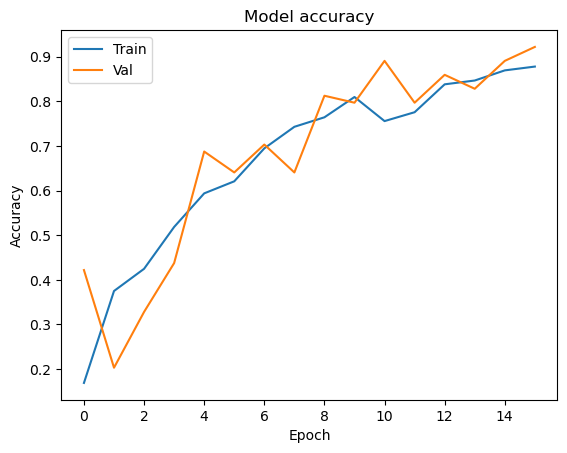

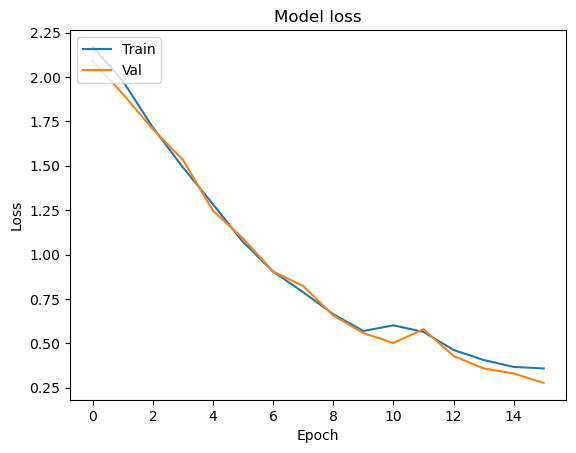

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9271 - loss: 0.2565
Test loss: 0.3278355300426483
Test accuracy: 0.890625


In [9]:
model_test3 = Sequential([
    LSTM(128, input_shape=X_shape, return_sequences=True),
    LSTM(128, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer"] = train_model(model_test3, 0.0001, EPOCH)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 30, 128)        │       229,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,865 (1.26 MB)

 Trainable params: 329,865 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 329ms/step - accuracy: 0.1443 - loss: 2.2360 - val_accuracy: 0.0781 - val_loss: 2.1510
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - accuracy: 0.2629 - loss: 2.0704 - val_accuracy: 0.4531 - val_loss: 2.0143
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.3858 - loss: 1.9562 - val_accuracy: 0.4844 - val_loss: 1.9176
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step - accuracy: 0.4183 - loss: 1.8277 - val_accuracy: 0.4688 - val_loss: 1.7912
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - accuracy: 0.4866 - loss: 1.7013 - val_accuracy: 0.5312 - val_loss: 1.6987
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.4742 - loss: 1.5836 - val_accuracy: 0.4688 - val_loss: 1.6210
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.4374 - loss: 1.5374 - val_accuracy: 0.5781 - val_loss: 1.5364
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.5562 - loss: 1.4044 - val_accuracy: 

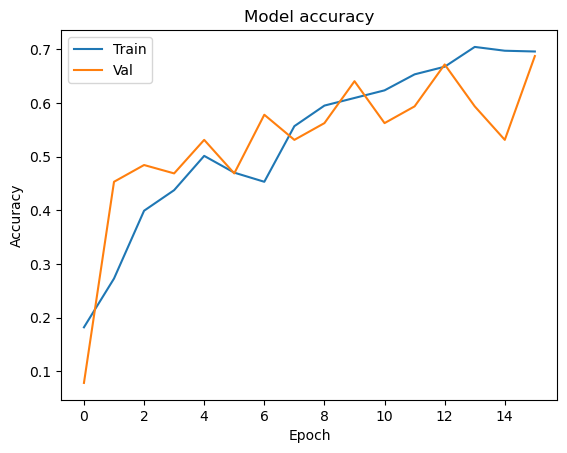

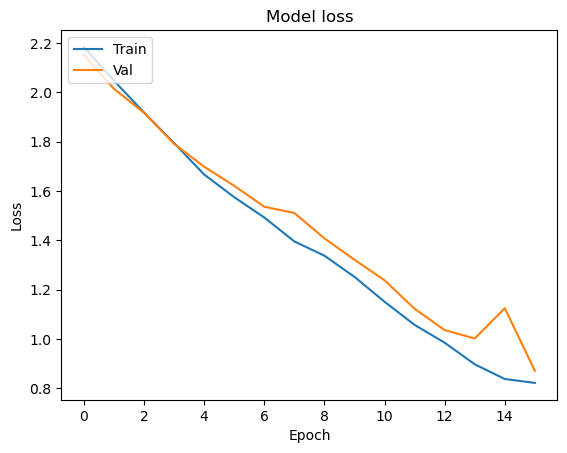

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7292 - loss: 0.8584
Test loss: 0.8876801133155823
Test accuracy: 0.703125


In [10]:
model_test4 = Sequential([
    GRU(128, input_shape=X_shape, return_sequences=True),
    GRU(128, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["GRU_double_layer"] = train_model(model_test4, 0.0001, EPOCH)

Now that we know LSTM is better, we test different learning rates.

# Test 3: Learning rates

Note: `lr=0.0001`, Test accuracy: 0.890625

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 128)        │       305,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,409 (1.67 MB)

 Trainable params: 438,409 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.0775 - loss: 2.2302 - val_accuracy: 0.1562 - val_loss: 2.1887
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.0951 - loss: 2.2145 - val_accuracy: 0.1562 - val_loss: 2.1802
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.1132 - loss: 2.1908 - val_accuracy: 0.1562 - val_loss: 2.1702
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.1348 - loss: 2.1737 - val_accuracy: 0.1562 - val_loss: 2.1608
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 254ms/step - accuracy: 0.2131 - loss: 2.1532 - val_accuracy: 0.1562 - val_loss: 2.1499
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step - accuracy: 0.2373 - loss: 2.1376 - val_accuracy: 0.1562 - val_loss: 2.1327
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.2784 - loss: 2.1173 - val_accuracy: 0.1562 - val_loss: 2.1125
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - accuracy: 0.2839 - loss: 2.0864 - val_accuracy: 0

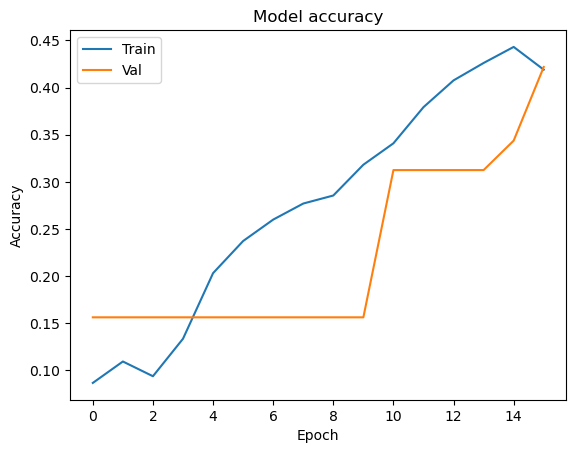

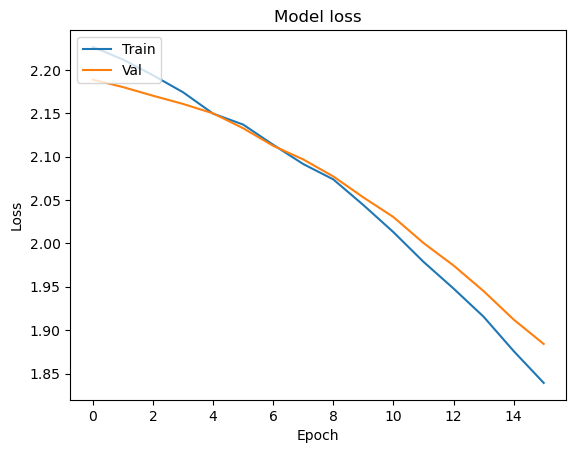

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5208 - loss: 1.8149
Test loss: 1.8859481811523438
Test accuracy: 0.390625


In [11]:
model_test5 = Sequential([
    LSTM(128, input_shape=X_shape, return_sequences=True),
    LSTM(128, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer_lr_0.00001"] = train_model(model_test5, 0.00001, EPOCH)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 30, 128)        │       305,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,409 (1.67 MB)

 Trainable params: 438,409 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - accuracy: 0.2081 - loss: 2.1033 - val_accuracy: 0.2344 - val_loss: 1.7113
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.4507 - loss: 1.4030 - val_accuracy: 0.2344 - val_loss: 1.6237
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.3938 - loss: 1.4948 - val_accuracy: 0.3438 - val_loss: 1.4918
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.4457 - loss: 1.3007 - val_accuracy: 0.5312 - val_loss: 1.2101
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.5000 - loss: 1.2007 - val_accuracy: 0.4688 - val_loss: 1.1040
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.5954 - loss: 0.9518 - val_accuracy: 0.4375 - val_loss: 1.2005
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.6000 - loss: 0.9915 - val_accuracy: 0.5000 - val_loss: 1.1941
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - accuracy: 0.5165 - loss: 1.2602 - val_accuracy: 0

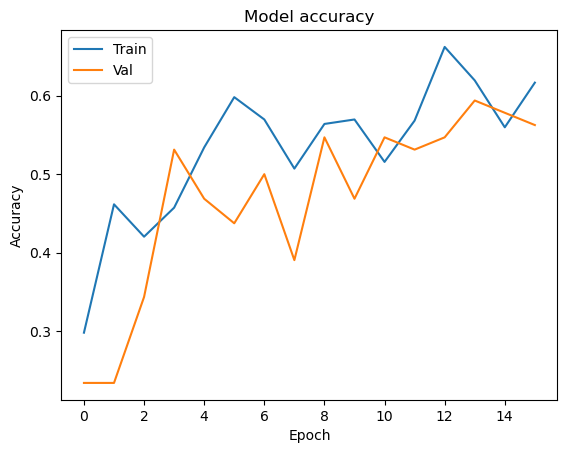

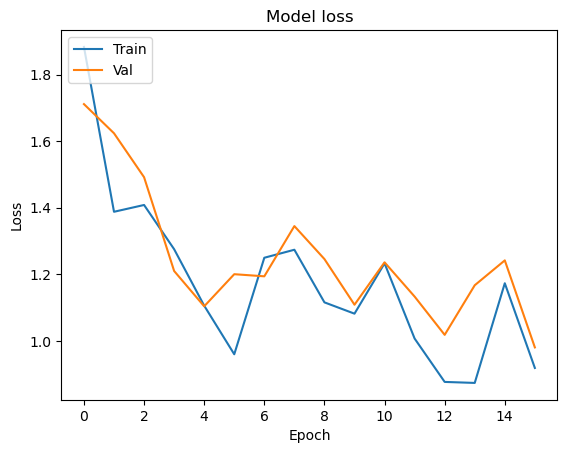

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5833 - loss: 0.8983
Test loss: 0.9431865811347961
Test accuracy: 0.546875


In [12]:
model_test6 = Sequential([
    LSTM(128, input_shape=X_shape, return_sequences=True),
    LSTM(128, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer_lr_0.001"] = train_model(model_test6, 0.001, EPOCH)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 30, 128)        │       305,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,409 (1.67 MB)

 Trainable params: 438,409 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 246ms/step - accuracy: 0.1124 - loss: 2.3169 - val_accuracy: 0.3125 - val_loss: 2.0511
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.2557 - loss: 1.9407 - val_accuracy: 0.2500 - val_loss: 1.9860
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - accuracy: 0.2272 - loss: 2.0102 - val_accuracy: 0.2500 - val_loss: 1.7764
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - accuracy: 0.3382 - loss: 1.6985 - val_accuracy: 0.3281 - val_loss: 1.8151
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.3600 - loss: 1.7365 - val_accuracy: 0.4688 - val_loss: 1.7120
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - accuracy: 0.3413 - loss: 1.6194 - val_accuracy: 0.4219 - val_loss: 1.4945
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - accuracy: 0.4024 - loss: 1.5539 - val_accuracy: 0.2188 - val_loss: 1.6442
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - accuracy: 0.3988 - loss: 1.5196 - val_accuracy: 0

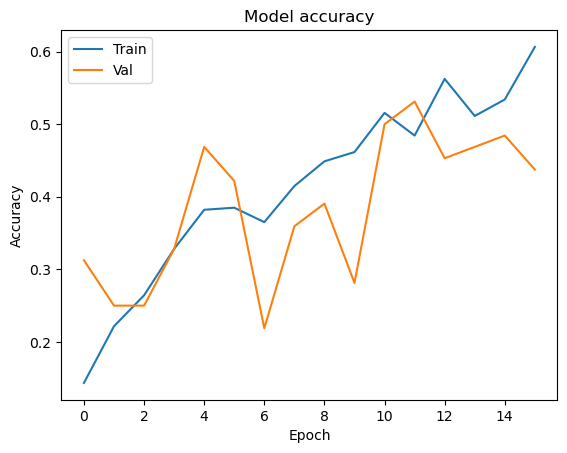

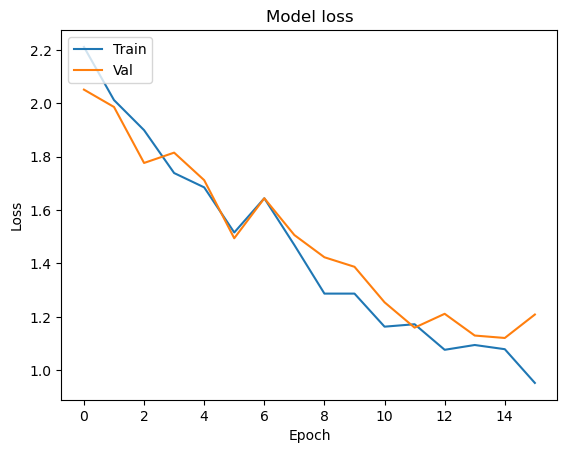

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4167 - loss: 1.1437
Test loss: 1.2468717098236084
Test accuracy: 0.40625


In [13]:
model_test7 = Sequential([
    LSTM(128, input_shape=X_shape, return_sequences=True),
    LSTM(128, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer_lr_0.01"] = train_model(model_test7, 0.01, EPOCH)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 30, 128)        │       305,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,409 (1.67 MB)

 Trainable params: 438,409 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - accuracy: 0.1014 - loss: 3.1357 - val_accuracy: 0.1562 - val_loss: 2.2677
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.1087 - loss: 2.3292 - val_accuracy: 0.1562 - val_loss: 2.3522
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.1219 - loss: 2.3592 - val_accuracy: 0.1562 - val_loss: 2.2386
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.1125 - loss: 2.3643 - val_accuracy: 0.1562 - val_loss: 2.4129
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.0958 - loss: 2.3519 - val_accuracy: 0.0000e+00 - val_loss: 2.7322
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.0921 - loss: 2.4809 - val_accuracy: 0.1562 - val_loss: 2.5427
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy: 0.1061 - loss: 2.4086 - val_accuracy: 0.1562 - val_loss: 2.2008
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.1319 - loss: 2.3812 - val_accurac

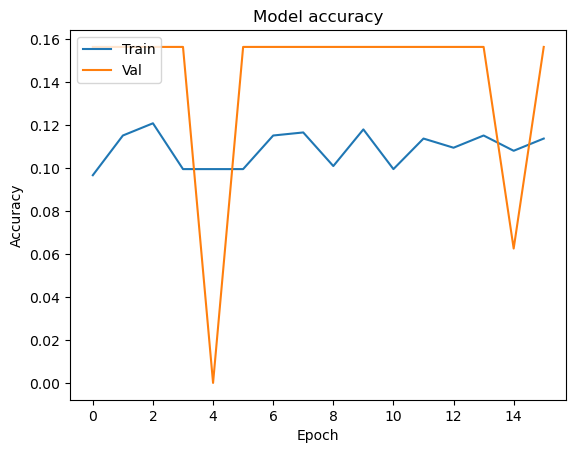

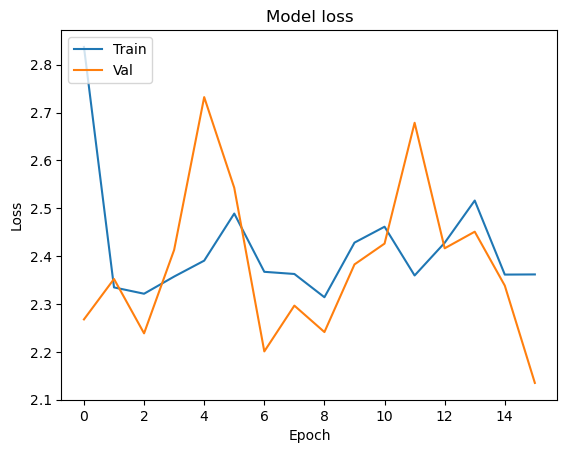

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2083 - loss: 2.1657
Test loss: 2.1349878311157227
Test accuracy: 0.15625


In [14]:
model_test8 = Sequential([
    LSTM(128, input_shape=X_shape, return_sequences=True),
    LSTM(128, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer_lr_0.1"] = train_model(model_test8, 0.1, EPOCH)

# Test 4: LSTM Unit count

Note: 128 units, Test accuracy: 0.890625

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 30, 64)         │       136,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,057 (664.29 KB)

 Trainable params: 170,057 (664.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 236ms/step - accuracy: 0.1027 - loss: 2.2332 - val_accuracy: 0.0000e+00 - val_loss: 2.1956
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.2098 - loss: 2.1609 - val_accuracy: 0.2812 - val_loss: 2.1314
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.3093 - loss: 2.0739 - val_accuracy: 0.2344 - val_loss: 2.0459
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.4697 - loss: 1.9250 - val_accuracy: 0.3594 - val_loss: 1.9345
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.5234 - loss: 1.7318 - val_accuracy: 0.5469 - val_loss: 1.7563
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.5085 - loss: 1.5928 - val_accuracy: 0.5781 - val_loss: 1.5900
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.5533 - loss: 1.4033 - val_accuracy: 0.6094 - val_loss: 1.3963
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.6058 - loss: 1.2230 - val_accurac

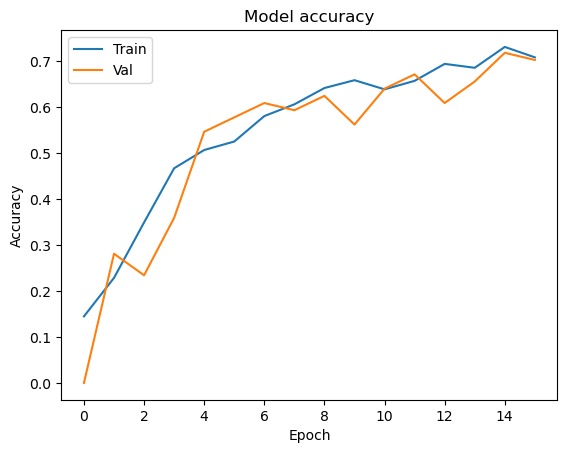

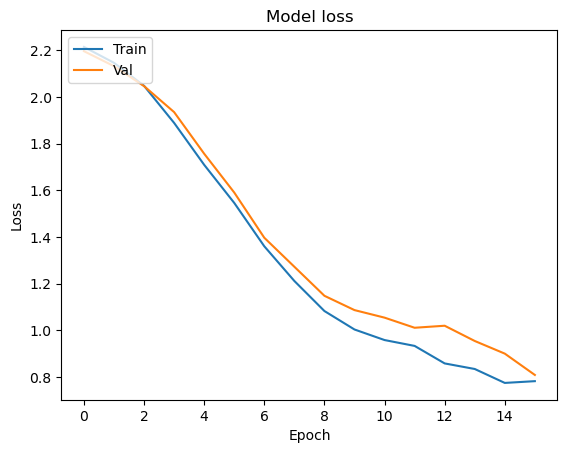

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7604 - loss: 0.7979
Test loss: 0.8575912714004517
Test accuracy: 0.71875


In [15]:
model_test9 = Sequential([
    LSTM(64, input_shape=X_shape, return_sequences=True),
    LSTM(64, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer_64"] = train_model(model_test9, 0.0001, EPOCH)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 30, 256)        │       742,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,270,025 (4.84 MB)

 Trainable params: 1,270,025 (4.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 304ms/step - accuracy: 0.1938 - loss: 2.1479 - val_accuracy: 0.3125 - val_loss: 1.9617
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - accuracy: 0.3895 - loss: 1.7893 - val_accuracy: 0.3125 - val_loss: 1.6633
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step - accuracy: 0.5456 - loss: 1.3599 - val_accuracy: 0.6406 - val_loss: 1.2802
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy: 0.6427 - loss: 1.0336 - val_accuracy: 0.5781 - val_loss: 0.9541
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy: 0.7128 - loss: 0.7928 - val_accuracy: 0.6250 - val_loss: 0.8821
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.6583 - loss: 0.8874 - val_accuracy: 0.5312 - val_loss: 1.5557
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy: 0.6931 - loss: 0.8459 - val_accuracy: 0.7344 - val_loss: 0.8085
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - accuracy: 0.7687 - loss: 0.6665 - val_accuracy: 0

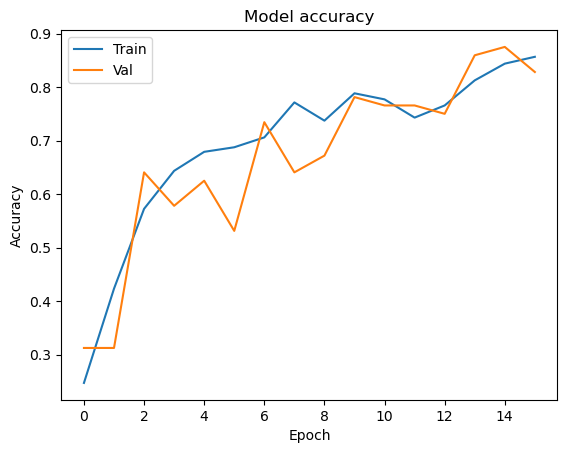

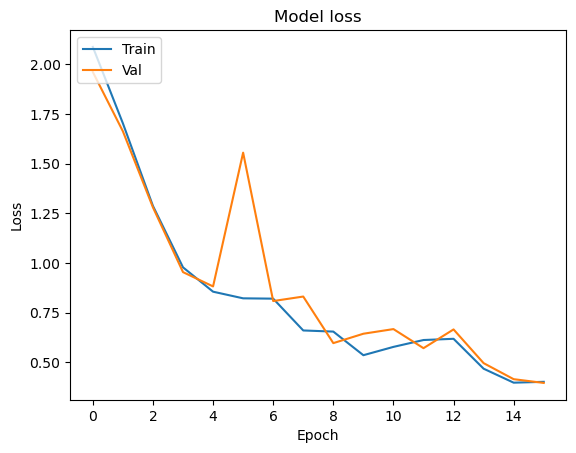

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9062 - loss: 0.2905
Test loss: 0.39052534103393555
Test accuracy: 0.859375


In [16]:
model_test10 = Sequential([
    LSTM(256, input_shape=X_shape, return_sequences=True),
    LSTM(256, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer_256"] = train_model(model_test10, 0.0001, EPOCH)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 30, 512)        │     2,009,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,112,905 (15.69 MB)

 Trainable params: 4,112,905 (15.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 439ms/step - accuracy: 0.2000 - loss: 2.1213 - val_accuracy: 0.5625 - val_loss: 1.6792
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 407ms/step - accuracy: 0.4510 - loss: 1.5153 - val_accuracy: 0.5312 - val_loss: 1.4032
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 423ms/step - accuracy: 0.5919 - loss: 1.1624 - val_accuracy: 0.5312 - val_loss: 1.2321
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 419ms/step - accuracy: 0.6449 - loss: 0.9266 - val_accuracy: 0.5156 - val_loss: 0.9079
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 479ms/step - accuracy: 0.6404 - loss: 0.8563 - val_accuracy: 0.6562 - val_loss: 0.7346
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 577ms/step - accuracy: 0.6908 - loss: 0.8347 - val_accuracy: 0.7344 - val_loss: 0.6915
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 525ms/step - accuracy: 0.7633 - loss: 0.6067 - val_accuracy: 0.6719 - val_loss: 0.8056
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 544ms/step - accuracy: 0.6928 - loss: 0.7769 - val_accu

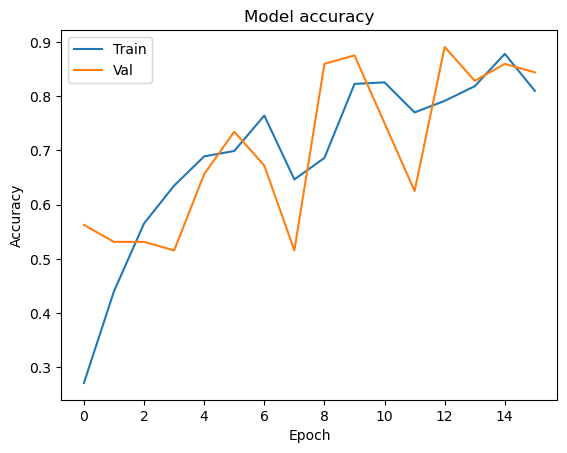

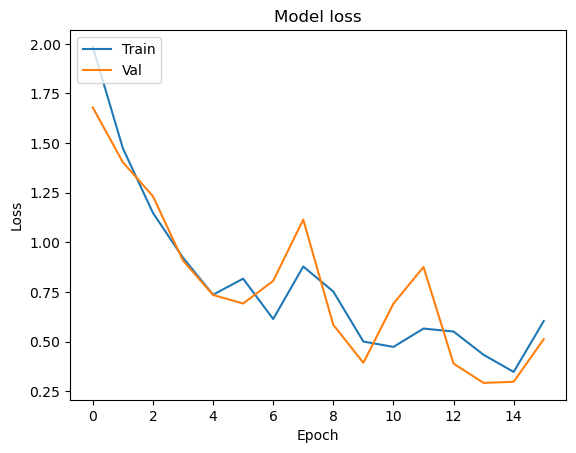

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8854 - loss: 0.3700
Test loss: 0.5186752080917358
Test accuracy: 0.828125


In [17]:
model_test11 = Sequential([
    LSTM(512, input_shape=X_shape, return_sequences=True),
    LSTM(512, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer_512"] = train_model(model_test11, 0.0001, EPOCH)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 30, 1024)       │     6,115,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 1024)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,517,257 (55.38 MB)

 Trainable params: 14,517,257 (55.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2182 - loss: 2.0446 - val_accuracy: 0.4688 - val_loss: 1.4626
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 975ms/step - accuracy: 0.4828 - loss: 1.3536 - val_accuracy: 0.5469 - val_loss: 1.1860
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5787 - loss: 1.0768 - val_accuracy: 0.6406 - val_loss: 0.9251
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6435 - loss: 0.8703 - val_accuracy: 0.6719 - val_loss: 0.7618
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 925ms/step - accuracy: 0.6549 - loss: 0.8268 - val_accuracy: 0.6250 - val_loss: 0.7191
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 922ms/step - accuracy: 0.6705 - loss: 0.7719 - val_accuracy: 0.7344 - val_loss: 0.6149
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7832 - loss: 0.5699 - val_accuracy: 0.7344 - val_loss: 0.5558
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 960ms/step - accuracy: 0.7334 - loss: 0.6346 - val_accuracy: 0.6250

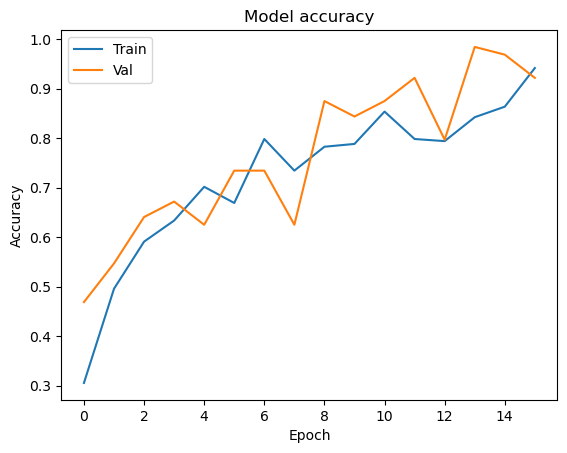

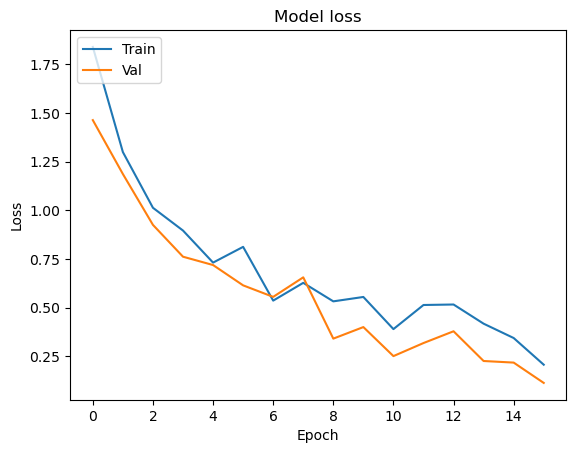

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9688 - loss: 0.0963
Test loss: 0.13805192708969116
Test accuracy: 0.953125


In [18]:
model_test12 = Sequential([
    LSTM(1024, input_shape=X_shape, return_sequences=True),
    LSTM(1024, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer_1024"] = train_model(model_test12, 0.0001, EPOCH)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 30, 2048)       │    20,619,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 2048)           │    33,562,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 9)              │        18,441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,200,329 (206.76 MB)

 Trainable params: 54,200,329 (206.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.2838 - loss: 2.0563 - val_accuracy: 0.5469 - val_loss: 1.3479
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.5172 - loss: 1.2787 - val_accuracy: 0.6250 - val_loss: 1.0514
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.6149 - loss: 0.9655 - val_accuracy: 0.6719 - val_loss: 0.8891
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.6867 - loss: 0.8123 - val_accuracy: 0.7188 - val_loss: 0.6074
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.7139 - loss: 0.6924 - val_accuracy: 0.5781 - val_loss: 0.8682
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.6200 - loss: 0.9011 - val_accuracy: 0.7969 - val_loss: 0.5358
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.7848 - loss: 0.5871 - val_accuracy: 0.8281 - val_loss: 0.4555
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.7944 - loss: 0.5473 - val_accuracy: 0.7812 - val_loss:

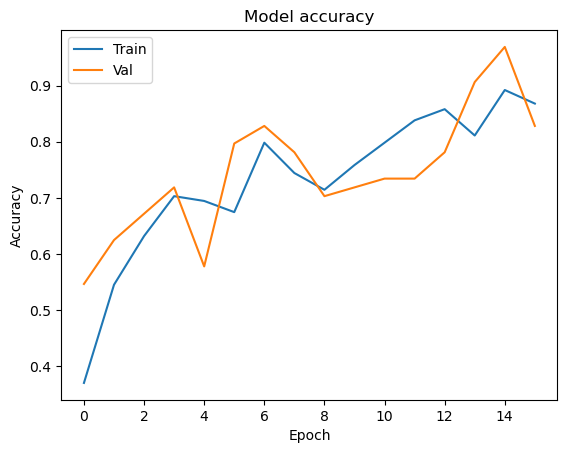

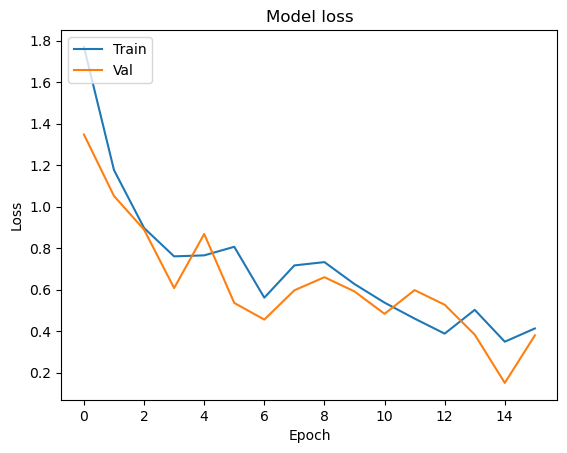

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step - accuracy: 0.8958 - loss: 0.3293
Test loss: 0.4635823667049408
Test accuracy: 0.84375


In [19]:
model_test13 = Sequential([
    LSTM(2048, input_shape=X_shape, return_sequences=True),
    LSTM(2048, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer_2048"] = train_model(model_test13, 0.0001, EPOCH)

# Summary

In [20]:
for key, value in results.items():
    print(key, value)

LSTM_single_layer (0.7585227489471436, 0.703125, 0.734375)
GRU_single_layer (0.6292613744735718, 0.46875, 0.515625)
LSTM_double_layer (0.8778409361839294, 0.921875, 0.890625)
GRU_double_layer (0.6960227489471436, 0.6875, 0.703125)
LSTM_double_layer_lr_0.00001 (0.41903409361839294, 0.421875, 0.390625)
LSTM_double_layer_lr_0.001 (0.6164772510528564, 0.5625, 0.546875)
LSTM_double_layer_lr_0.01 (0.6065340638160706, 0.4375, 0.40625)
LSTM_double_layer_lr_0.1 (0.11363636702299118, 0.15625, 0.15625)
LSTM_double_layer_64 (0.7088068127632141, 0.703125, 0.71875)
LSTM_double_layer_256 (0.8565340638160706, 0.828125, 0.859375)
LSTM_double_layer_512 (0.8096590638160706, 0.84375, 0.828125)
LSTM_double_layer_1024 (0.9417613744735718, 0.921875, 0.953125)
LSTM_double_layer_2048 (0.8678977489471436, 0.828125, 0.84375)


# Conclusion

From the above experiments, we get
- LSTM is **way** better than GRU
- Multi-layer is better than single layer
- `lr=0.0001`
- Units: `256`